In [23]:
import pandas as pd
import numpy as np
from gurobipy import Model, GRB, quicksum


In [24]:
# Define indices
I = [1, 2, 3, 4, 5]   # Facility locations
J = [1, 2, 3, 4, 5, 6, 7]  # Demand points
K = [1, 2, 3, 4, 5]   # Number of facilities covering a demand point


# Input distance data from Table 1 (in kilometers)
distance_data = {
    (1, 1): 12, (1, 2): 42, (1, 3): 34, (1, 4): 16, (1, 5): 29, (1, 6): 49, (1, 7): 19,
    (2, 1): 41, (2, 2): 41, (2, 3): 15, (2, 4): 14, (2, 5): 21, (2, 6): 12, (2, 7): 20,
    (3, 1): 15, (3, 2): 43, (3, 3): 45, (3, 4): 13, (3, 5): 19, (3, 6): 40, (3, 7): 50,
    (4, 1): 45, (4, 2): 20, (4, 3): 30, (4, 4): 20, (4, 5): 10, (4, 6): 23, (4, 7): 13,
    (5, 1): 15, (5, 2): 25, (5, 3): 19, (5, 4): 34, (5, 5): 38, (5, 6): 11, (5, 7): 31,
}



In [25]:
# Average speed in km/min
average_speed = 65 / 60  # km per minute

# Calculate travel times (in minutes)
travel_times = {}
for (i, j), dist in distance_data.items():
    travel_times[(i, j)] = dist / average_speed

# Determine coverage indicator a_{ij}
a_ij = {}
for i in I:
    for j in J:
        travel_time = travel_times.get((i, j), np.inf)
        a_ij[(i, j)] = 1 if travel_time <= 20 else 0

# Busy probability q
q = 0.2

# Coefficients for the objective function
coeffs = {}
for k in K:
    coeffs[k] = (1 - q) * q ** (k - 1)

# Demand values h_j from Table 2
h_j = {
    1: 30,
    2: 12,
    3: 15,
    4: 28,
    5: 12,
    6: 17,
    7: 14
}

# Cost per facility and total budget
c = 50000    # Annual cost per fire station ($)
B = 180000   # Total annual budget ($)


In [26]:

# Create the model
model = Model("UpdatedFireStationLocation")

# Variables
y = model.addVars(I, vtype=GRB.INTEGER, lb=0, name='y')        # Number of facilities at location i
z = model.addVars(J, K, vtype=GRB.BINARY, name='z')            # Binary variable for coverage levels

# Objective Function
model.setObjective(
    quicksum(h_j[j] * quicksum(coeffs[k] * z[j, k] for k in K) for j in J),
    GRB.MAXIMIZE
)

# Constraints


for j in J:
    model.addConstr(quicksum( z[j, k] for k in K) <= quicksum(a_ij.get((i, j), 0) * y[i] for i in I), name=f"j_def_{j}")

# Budget constraint
model.addConstr(c * quicksum(y[i] for i in I) <= B, name="budget")

# Optimize the model
model.optimize()



Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-9300HF CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 8 rows, 40 columns and 58 nonzeros
Model fingerprint: 0xbf2647b7
Variable types: 0 continuous, 40 integer (35 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+04]
  Objective range  [2e-02, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+05, 2e+05]
Found heuristic solution: objective -0.0000000
Presolve removed 0 rows and 2 columns
Presolve time: 0.00s
Presolved: 8 rows, 38 columns, 56 nonzeros
Variable types: 0 continuous, 38 integer (33 binary)
Found heuristic solution: objective 71.4240000

Root relaxation: objective 1.207552e+02, 13 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbe

In [27]:

# Check if the model has an optimal solution
if model.status == GRB.OPTIMAL:
    print("\nOptimal Solution Found:")
    
    # Number of facilities at each location
    print("\nNumber of facilities at each location (y_i):")
    for i in I:
        num_facilities = y[i].x
        print(f"Location {i}: {int(num_facilities)} facility(ies)")
    
    # Coverage details for each demand point
    print("\nCoverage details for each demand point:")
    for j in J:
        covered_by = []
        for i in I:
            if y[i].x > 0.5 and a_ij.get((i, j), 0) == 1:
                covered_by.append(f"Location {i}")
        if covered_by:
            covered_by_str = ", ".join(covered_by)
            print(f"Demand point {j} is covered by: {covered_by_str}")
        else:
            print(f"Demand point {j} is not covered by any facility.")
    
    # Total expected demand covered
    total_covered = model.objVal
    print(f"\nTotal Expected Demand Covered: {total_covered}")
else:
    print("\nNo optimal solution found.")



Optimal Solution Found:

Number of facilities at each location (y_i):
Location 1: 0 facility(ies)
Location 2: 1 facility(ies)
Location 3: 0 facility(ies)
Location 4: 1 facility(ies)
Location 5: 1 facility(ies)

Coverage details for each demand point:
Demand point 1 is covered by: Location 5
Demand point 2 is covered by: Location 4
Demand point 3 is covered by: Location 2, Location 5
Demand point 4 is covered by: Location 2, Location 4
Demand point 5 is covered by: Location 2, Location 4
Demand point 6 is covered by: Location 2, Location 5
Demand point 7 is covered by: Location 2, Location 4

Total Expected Demand Covered: 116.16


Question2

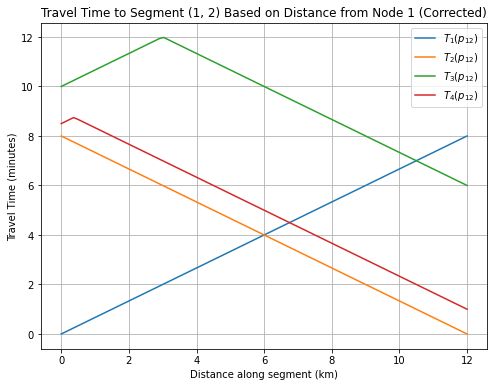

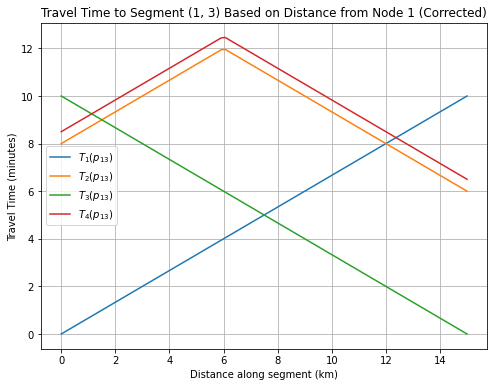

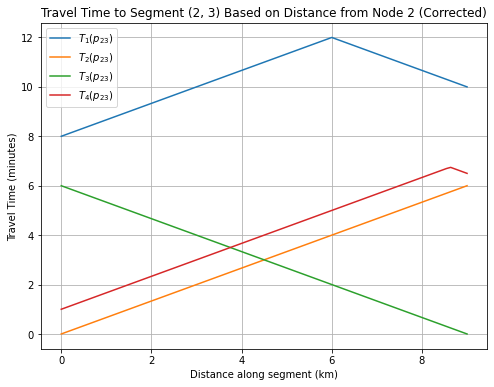

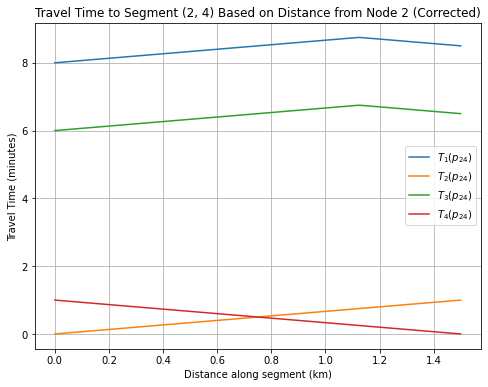

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Corrected travel time matrix for node pairs (Table 2)
node_times = np.array([
    [0, 8, 10, 8.5],  # Node 1
    [8, 0, 6, 1],     # Node 2 
    [10, 6, 0, 6.5],  # Node 3
    [8.5, 1, 6.5, 0]  # Node 4
])

# Table 1: Segment length (km) and travel time (min)
segments = {
    (1, 2): {'length': 12, 'time': 8},
    (1, 3): {'length': 15, 'time': 10},
    (2, 3): {'length': 9, 'time': 6},
    (2, 4): {'length': 1.5, 'time': 1}
}

# Define nodes and segment pairs
nodes = [1, 2, 3, 4]
segment_pairs = list(segments.keys())

# Function to calculate travel time based on distance along the segment
def calculate_travel_time_distance(i, h, k, distance):
    ti_h = node_times[i-1][h-1]
    ti_k = node_times[i-1][k-1]
    segment_length = segments[(h, k)]['length']
    tau_h_pk = distance * (segments[(h, k)]['time'] / segment_length)  # Travel time based on distance along segment
    return min(ti_h + tau_h_pk, ti_k + (segments[(h, k)]['time'] - tau_h_pk))


# Visualize the travel time function for each segment and each node
for h, k in segment_pairs:
    plt.figure(figsize=(8, 6))
    alpha_values = np.linspace(0, 1, 100)  # 100 points along the segment

    segment_length = segments[(h, k)]['length']

    # Generate distances from 0 to segment_length for plotting
    distance_values = np.linspace(0, segment_length, 100)

    # Plot travel time for each node as a function of distance along the segment (1, 2)
    for i in nodes:
        travel_times = [calculate_travel_time_distance(i, h, k, distance) for distance in distance_values]
        plt.plot(distance_values, travel_times, label=f"$T_{i}(p_{{{h}{k}}})$")

    plt.title(f"Travel Time to Segment ({h}, {k}) Based on Distance from Node {h} (Corrected)")
    plt.xlabel("Distance along segment (km)")
    plt.ylabel("Travel Time (minutes)")
    plt.legend()
    plt.grid(True)
    plt.show()


In [29]:
# Function to calculate the maximum travel time for each node for a given distance on a segment
def max_travel_time_along_segment(h, k, distance):
    return max(calculate_travel_time_distance(i, h, k, distance) for i in nodes)

# Find the local center (p^*_{hk}) that minimizes the maximum travel time for each segment
optimal_points = {}  # Dictionary to store the optimal point for each segment and its max travel time

for h, k in segment_pairs:
    segment_length = segments[(h, k)]['length']
    distance_values = np.linspace(0, segment_length, 1000)  

    # Calculate the maximum travel time at each point along the segment
    max_travel_times = [max_travel_time_along_segment(h, k, distance) for distance in distance_values]

    # Find the point along the segment that minimizes the maximum travel time
    min_max_travel_time = min(max_travel_times)
    optimal_distance = distance_values[max_travel_times.index(min_max_travel_time)]

    # Store the result for this segment
    optimal_points[(h, k)] = {'optimal_distance': optimal_distance, 'min_max_travel_time': min_max_travel_time}

    print(f"Segment ({h}, {k}): Optimal point at {optimal_distance:.2f} km with minimum max travel time of {min_max_travel_time:.2f} minutes")

# The 'optimal_points' dictionary now contains the optimal placement and corresponding minimum max travel time for each segment.


Segment (1, 2): Optimal point at 10.50 km with minimum max travel time of 7.00 minutes
Segment (1, 3): Optimal point at 12.37 km with minimum max travel time of 8.25 minutes
Segment (2, 3): Optimal point at 0.00 km with minimum max travel time of 8.00 minutes
Segment (2, 4): Optimal point at 0.00 km with minimum max travel time of 8.00 minutes
